In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb

import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.base import clone

from processing_functions import *

In [2]:
df = pd.read_csv('data/input_file.csv')
#nan_percentage(df) 

There is a lot of data missing for how people think others perceive them, and what attributes they think the rest of their sex prefer. 

Since I am also going to be working with no gender, I will drop any column related to the binary separation of gender.

The attribute that overall has the most amount of missing data is 'shared interests'. I was hoping to use this attribute as a reliable feature to find partners, but based on the findings made in the EDA it is the feature that is the least important. 

In [3]:
def drop_columns(df, suffix):
    cols = [col for col in df.columns if any(col.endswith(s) for s in suffix)]
    
    df = df.drop(columns=cols, errors='ignore')
    
    return df
    

suffix= ['_fellow_want', 'perceived', '_o_want', '_diff']
df = drop_columns(df, suffix)
df = df.drop(columns=['Unnamed: 0'])

Since there are too many people and waves in this experiment, I am going to opt to drop the rows that have nan values so that it is easier to work with when it comes to training the dataset (especially with Random Forest). 

In [4]:
df.head()

,iid,id,wave,partner,pid,match,int_corr,age_o,pf_o_att,pf_o_sin,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,1,1.0,1,1,11.0,0,0.14,27.0,35.0,20.0,...,4,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,1,1.0,1,2,12.0,0,0.54,22.0,60.0,0.0,...,4,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
2,1,1.0,1,3,13.0,1,0.16,22.0,19.0,18.0,...,4,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN
3,1,1.0,1,4,14.0,1,0.61,23.0,30.0,5.0,...,4,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,1.0,1,5,15.0,1,0.21,24.0,30.0,10.0,...,4,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0


In [5]:
df = df.dropna()
df

,iid,id,wave,partner,pid,match,int_corr,age_o,pf_o_att,pf_o_sin,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,1,1.0,1,1,11.0,0,0.14,27.0,35.0,20.0,...,4,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,1,1.0,1,2,12.0,0,0.54,22.0,60.0,0.0,...,4,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
3,1,1.0,1,4,14.0,1,0.61,23.0,30.0,5.0,...,4,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,1.0,1,5,15.0,1,0.21,24.0,30.0,10.0,...,4,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0
5,1,1.0,1,6,16.0,0,0.25,25.0,50.0,0.0,...,4,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,131,10.0,5,1,112.0,0,0.35,20.0,15.0,15.0,...,3,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0
1837,131,10.0,5,2,113.0,0,0.45,21.0,15.0,15.0,...,2,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0
1838,131,10.0,5,3,114.0,0,0.13,20.0,20.0,20.0,...,3,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0
1840,131,10.0,5,5,116.0,0,0.54,21.0,15.0,15.0,...,2,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0


In [6]:
# Dropping identifier columns and irrelevant features for prediction
df = df.drop(columns=['iid', 'id', 'pid', 'partner', 'wave'], axis=1)

In [7]:
df.head()

,match,int_corr,age_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,0,0.14,27.0,35.0,20.0,20.0,20.0,0.0,5.0,0,...,4,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,0,0.54,22.0,60.0,0.0,0.0,40.0,0.0,0.0,0,...,4,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
3,1,0.61,23.0,30.0,5.0,15.0,40.0,5.0,5.0,1,...,4,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,0.21,24.0,30.0,10.0,20.0,10.0,10.0,20.0,1,...,4,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0
5,0,0.25,25.0,50.0,0.0,30.0,10.0,0.0,10.0,1,...,4,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0


In [8]:
X = df.drop(['match', 'dec', 'dec_o'], axis=1)
y = df['match']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [9]:
# Start by modelling a LightGBM and Random Forest model 
# Will do comparison of both and decide based on 
# maybe can try to use LightGBM but using 'random forest' as the boosting_type(?)

lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)

lgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [10]:
rf_accuracy = cross_val_score(rf_model, X_train, y_train, cv=5)
lgb_accuracy = cross_val_score(lgb_model, X_train, y_train, cv=5)
xgb_accuracy = cross_val_score(xgb_model, X_train, y_train, cv=5)

print("Random Forest Accuracy: ", rf_accuracy.mean())
print("LightGBM Accuracy: ", lgb_accuracy.mean())
print("XGBClassifier Accuracy: ", xgb_accuracy.mean())

Random Forest Accuracy:  0.8400000000000001
LightGBM Accuracy:  0.8466666666666667
XGBClassifier Accuracy:  0.8493333333333333


In [29]:
from sklearn.metrics import f1_score

def find_best_threshold(model):
    # Predict probabilities for the positive class
    probabilities = model.predict(X_test)
    
    # Initialize variables to store the best score and corresponding threshold
    best_threshold = 0
    best_f1 = 0
    
    # Test all possible thresholds from 0 to 1 at a fine granularity
    for threshold in np.linspace(0, 1, 100):
        # Convert probabilities to binary predictions based on the current threshold
        predictions = (model.predict(X_test) >= threshold).astype(int)
        
        # Calculate the F1 score
        f1 = f1_score(y_test, predictions)
        
        # If the current F1 score is better than the best score found so far
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold, best_f1

# Usage example:
# Assuming model, X_test, and y_test are defined
best_threshold_lgb, best_f1_lgb = find_best_threshold(lgb_model)
print("Best Threshold lgb:", best_threshold_lgb)
print("Best F1 Score lgb:", best_f1_lgb, "\n")

best_threshold_rf, best_f1_rf = find_best_threshold(rf_model)
print("Best Threshold rf:", best_threshold_rf)
print("Best F1 Score rf:", best_f1_rf, "\n")

best_threshold_xgb, best_f1_xgb = find_best_threshold(xgb_model)
print("Best Threshold xgb:", best_threshold_xgb)
print("Best F1 Score xgb:", best_f1_xgb, "\n")

Best Threshold lgb: 0.010101010101010102
Best F1 Score lgb: 0.5789473684210527 

Best Threshold rf: 0.010101010101010102
Best F1 Score rf: 0.5074626865671642 

Best Threshold xgb: 0.010101010101010102
Best F1 Score xgb: 0.6250000000000001 



In [14]:
best_f1 = max(best_f1_lgb, best_f1_rf, best_f1_xgb)
print("Best F1 Score:", best_f1)

Best F1 Score: 0.6614173228346457


In [36]:
# Comparison between models with classification_report
# Make prediction on the testing data
y_pred_rf = rf_model.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Classification Report
print("RandomForestClassifier:\n", classification_report(y_test, y_pred_rf, zero_division=0))
print("LightGBM:\n", classification_report(y_pred_lgb, y_test))
print("XGBClassifer:\n", classification_report(y_pred_xgb, y_test))

print("\n")

# F1 Score
print("RandomForestClassifier F1 score:\n", f1_score(y_test, y_pred_rf, zero_division=0, average="weighted"),"\n")
print("LightGBM F1 score:\n", f1_score(y_pred_lgb, y_test, average="weighted"),"\n")
print("XGBClassifer F1 score:\n", f1_score(y_pred_xgb, y_test, average="weighted"))

RandomForestClassifier:
               precision    recall  f1-score   support

           0       0.89      0.97      0.92       208
           1       0.71      0.40      0.51        43

    accuracy                           0.87       251
   macro avg       0.80      0.68      0.72       251
weighted avg       0.86      0.87      0.85       251

LightGBM:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92       218
           1       0.51      0.67      0.58        33

    accuracy                           0.87       251
   macro avg       0.73      0.79      0.75       251
weighted avg       0.89      0.87      0.88       251

XGBClassifer:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       214
           1       0.58      0.68      0.63        37

    accuracy                           0.88       251
   macro avg       0.76      0.80      0.78       251
weighted avg       0.89

In [ ]:
df['match'].value_counts(normalize=True)

After looking at the accuracy and the other metrics we can see that, same as had previously measured in the EDA, this is a very unbalanced dataset. Almost 80% of the values belong to 0, while only 20% is part of the positive results.

There is a much higher number of 0s (no matches) than 1s (matches), there this makes the precision, accuracy and recall of the matches much more lower than the no matches.

We need to find a weight balance in order to work with it and in return choose the most appropriate model to work with.
References found in: [https://stackoverflow.com/questions/51190809/high-auc-but-bad-predictions-with-imbalanced-data]

We might also want to look into the performance of a =XGBoost= model since it performs better for unbalanced data. 
The boosting algorithm iteratively learns from the mistakes of the previous tree. So if a tree fails to predict a class (most likely the imbalanced class), the proceeding tree will give more weightage to this sample.

In [23]:
def pr_threshold(model, model_name='Model'):
    """
    Calculate and plot the precision-recall curve for a given model and test data.
    Also, find the threshold that yields the highest F1 score using an iterative method and plot the classification report based on this threshold.

    Parameters:
    model: The trained classifier to evaluate.
    X_test: The test features.
    y_test: The true labels for the test set.
    model_name (optional): Name of the model to include in the plot title.

    Returns:
    optimal_threshold: The threshold value that yields the highest F1 score.
    optimal_report: Classification report using the optimal threshold.
    """
    # probabilities for the positive class
    probabilities = model.predict_proba(X_val)[:, 1]

    # precision, recall, and thresholds using the predicted probabilities
    precision, recall, thresholds = precision_recall_curve(y_val, probabilities)

    # F1 score for each threshold with tiny constant to avoid division by zero
    fscore = (2 * precision * recall) / (precision + recall + 1e-12)

    # Find the index of the maximum F1 score
    optimal_index = np.argmax(fscore)
    best_threshold = thresholds[optimal_index]

    # Make final predictions using the optimal threshold
    final_predictions = (model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
    plt.plot(thresholds, (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12), 'r-.', label='F1 Score')
    plt.axvline(x=best_threshold, color='k', linestyle='--', label='Optimal Threshold')
    plt.xlabel('Threshold')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.title(f'{model_name}: Precision, Recall, and F1 Score for different thresholds')
    plt.show()

    optimal_report = classification_report(y_test, final_predictions, zero_division=0)
    return best_threshold, optimal_report

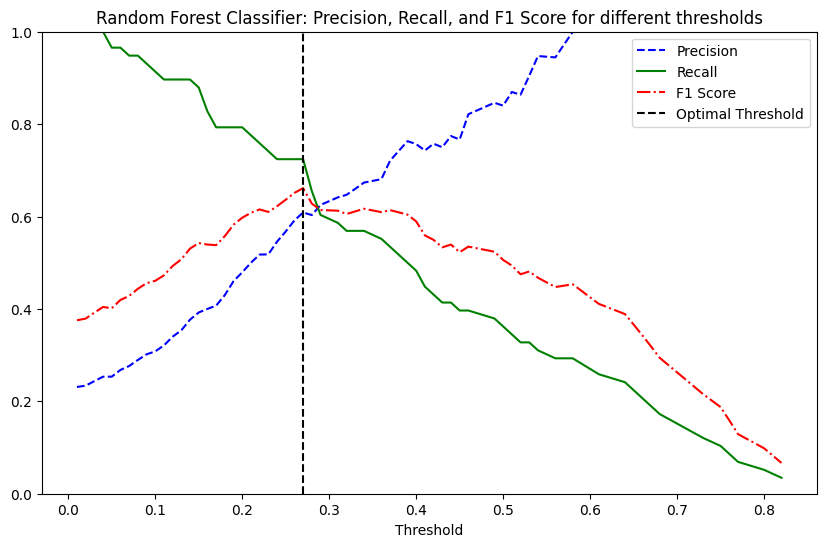

Optimal threshold for maximum Random Forest F1-score: 0.27
Using threshold ~0.2700 for evaluation.

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       208
           1       0.45      0.72      0.55        43

    accuracy                           0.80       251
   macro avg       0.69      0.77      0.71       251
weighted avg       0.85      0.80      0.82       251
 

Random Forest: f1 score 0.8842964733961732


In [44]:
optimal_threshold_rf, optimal_report_rf = pr_threshold(rf_model, model_name='Random Forest Classifier')

print("Optimal threshold for maximum Random Forest F1-score:", optimal_threshold_rf)
print(f"Using threshold ~{optimal_threshold_rf:.4f} for evaluation.\n")
print(optimal_report_rf, "\n")

final_predictions = (rf_model.predict(X_test) >= 0.27).astype(int)
print("Random Forest: f1 score", f1_score(final_predictions, y_test, average="weighted"))

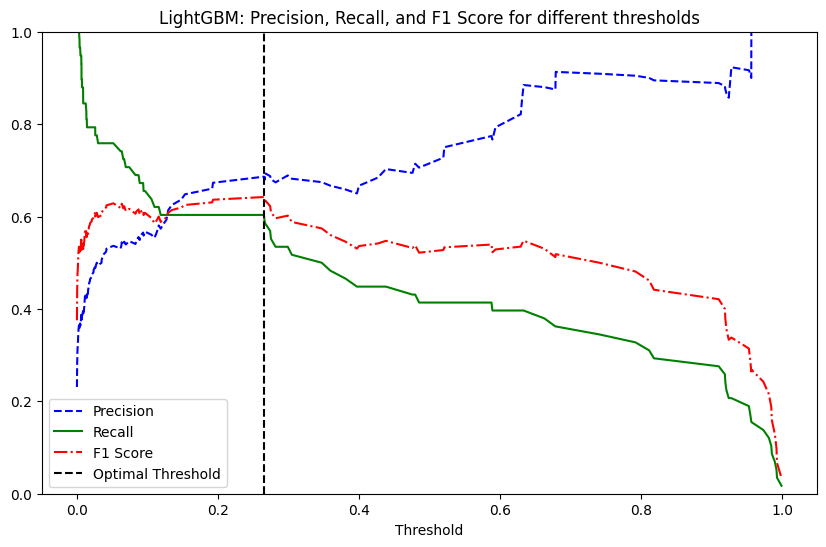

Optimal threshold for maximum LightGBM F1-score: 0.2651740554004903
Using threshold ~0.2652 for evaluation.

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       208
           1       0.52      0.60      0.56        43

    accuracy                           0.84       251
   macro avg       0.72      0.74      0.73       251
weighted avg       0.85      0.84      0.84       251

LightGBM: F1 score 0.8794011008104966


In [42]:
optimal_threshold_lgb, optimal_report_lgb = pr_threshold(lgb_model, model_name='LightGBM')

print("Optimal threshold for maximum LightGBM F1-score:", optimal_threshold_lgb)
print(f"Using threshold ~{optimal_threshold_lgb:.4f} for evaluation.\n")
print(optimal_report_lgb)

final_predictions = (lgb_model.predict(X_test) >= 0.27).astype(int)
print("LightGBM: F1 score", f1_score(final_predictions, y_test, average="weighted"))

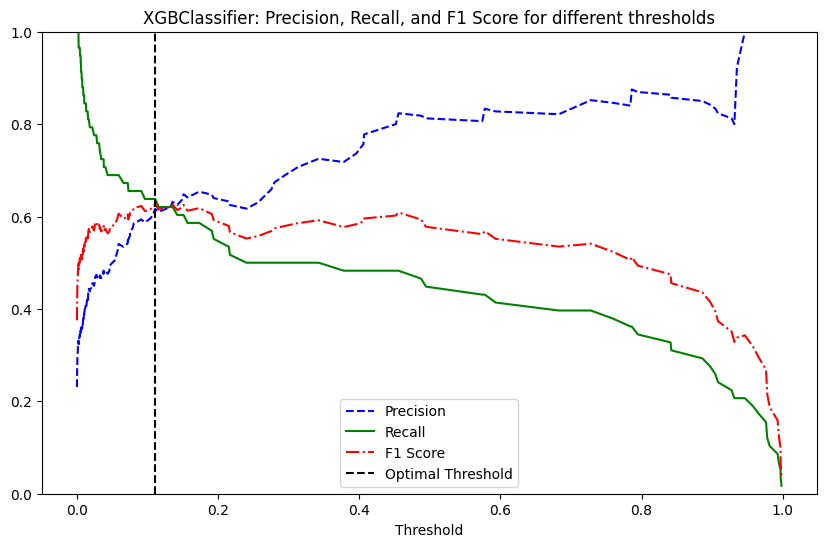

Optimal threshold for maximum XGBClassifier F1-score: 0.110966824
Using threshold ~0.1110 for evaluation.

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       208
           1       0.45      0.70      0.55        43

    accuracy                           0.80       251
   macro avg       0.69      0.76      0.71       251
weighted avg       0.85      0.80      0.82       251

XGBClassifier: F1 score 0.8841104775211948


In [43]:
optimal_threshold_xgb, optimal_report_xgb = pr_threshold(xgb_model, model_name='XGBClassifier')

print("Optimal threshold for maximum XGBClassifier F1-score:", optimal_threshold_xgb)
print(f"Using threshold ~{optimal_threshold_xgb:.4f} for evaluation.\n")
print(optimal_report_xgb)

final_predictions = (xgb_model.predict(X_test) >= 0.27).astype(int)
print("XGBClassifier: F1 score", f1_score(final_predictions, y_test, average="weighted"))

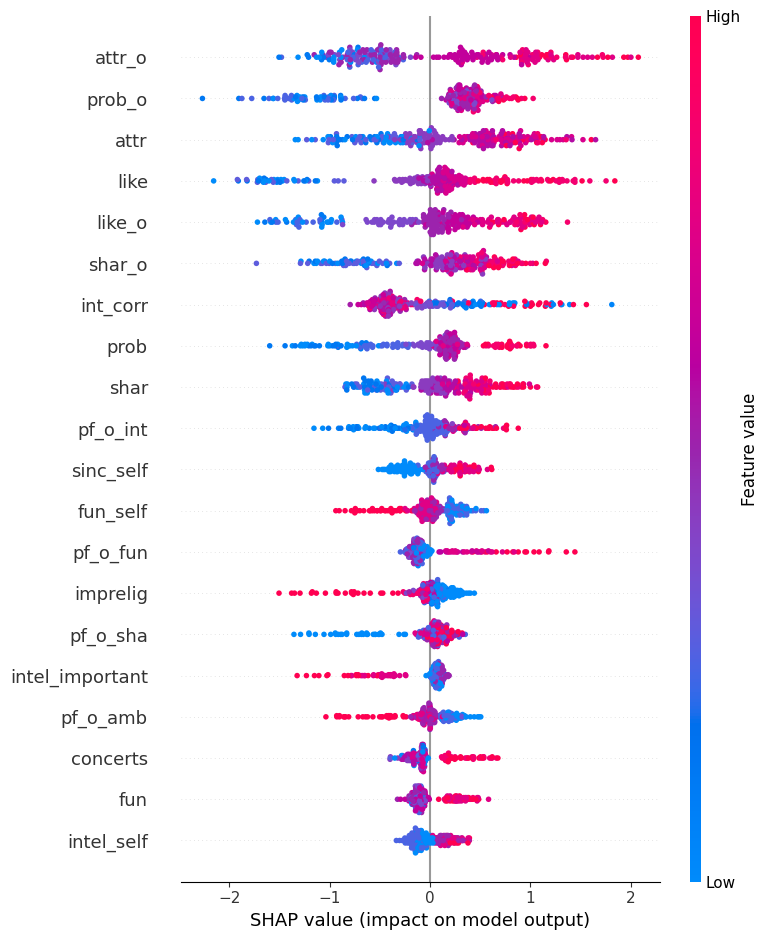

In [54]:
explainer = shap.Explainer(lgb_model, X_train)
shap_values_lgb = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values_lgb, X_test)

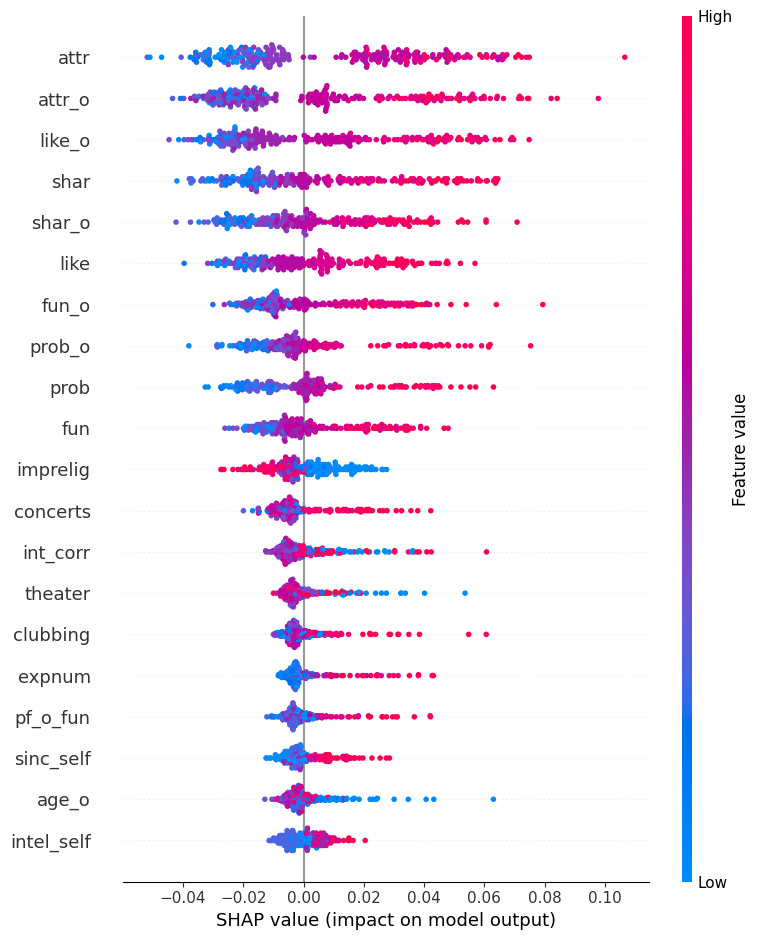

In [57]:
explainer = shap.Explainer(rf_model, X_train)
shap_values_rf = explainer.shap_values(X_test, check_additivity=False)

# Visualize the SHAP values
shap.summary_plot(shap_values_rf[1], X_test)

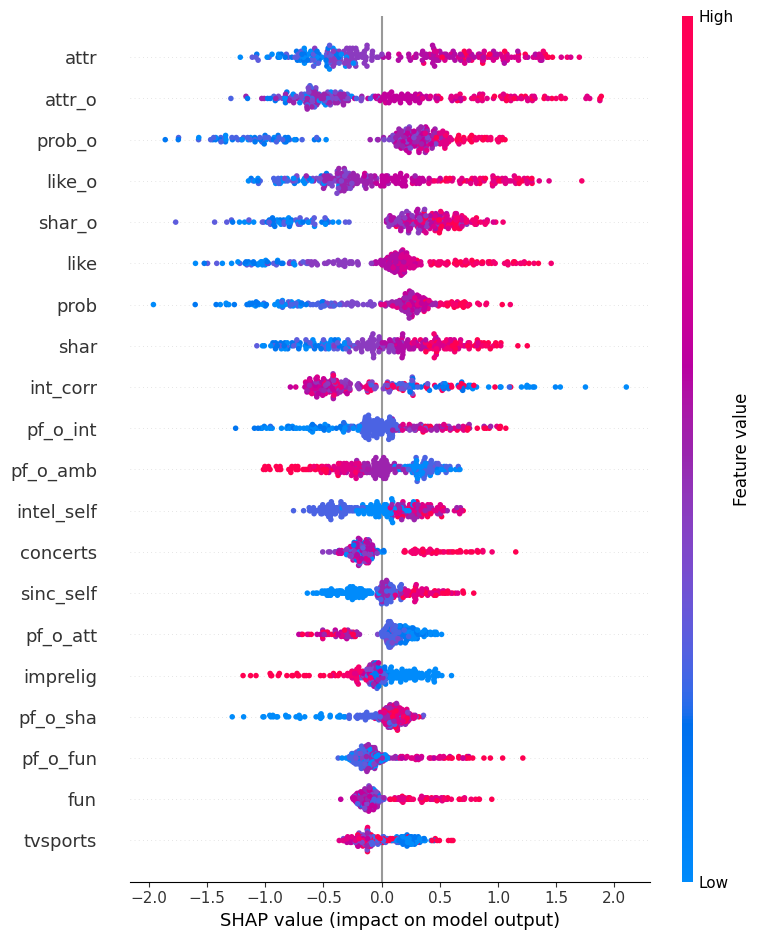

In [58]:
explainer = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values_xgb, X_test)

In [79]:
def global_shap_importance2(model):
    """
    Return a dataframe containing the features sorted by Shap importance.

    Parameters:
    model : The tree-based model (like RandomForest, XGBoost, etc.).
    X_train : pd.DataFrame
        Training set used to train the model (without the label).
    X_test : pd.DataFrame
        Test set or any set to compute SHAP values (without the label).

    Returns:
    pd.DataFrame
        A dataframe containing the features sorted by Shap importance.
    """
    # Initialize the SHAP explainer on the training set
    explainer = shap.Explainer(model, X_train)
    
    # Compute SHAP values for the test set
    shap_values = explainer.shap_values(X_test, check_additivity=False)
    
    # Ensure shap_values is a numpy array and calculate mean absolute values
    if isinstance(shap_values, list):  # Handling models with multi-class outputs
        shap_values = np.abs(shap_values[1])  # Consider only the first class or adjust as needed
    else:
        shap_values = np.abs(shap_values)
        
    mean_abs_shap_values = shap_values.mean(axis=0)
    
    # Create a DataFrame linking feature names with their corresponding mean SHAP values
    feature_importance = pd.DataFrame({
        'features': X_test.columns,
        'importance': mean_abs_shap_values
    })
    
    # Sort the DataFrame by 'importance' in descending order
    feature_importance.sort_values(by='importance', ascending=False, inplace=True)
    
    return feature_importance.reset_index().drop(columns='index').head(10)

In [80]:
global_shap_importance2(rf_model)

,features,importance
0,attr,0.028349
1,attr_o,0.026042
2,like_o,0.024803
3,shar,0.020862
4,shar_o,0.017561
5,like,0.016056
6,fun_o,0.015508
7,prob_o,0.013172
8,prob,0.013082
9,fun,0.012068
